## Figure 2 From Paper

In [1]:
import symd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import pandas as pd
import skunk
import svglib
import seaborn as sns
import gzip
import urllib

In [2]:
base_colors = [
    "f94144",
    "f3722c",
    "f8961e",
    "f9844a",
    "f9c74f",
    "90be6d",
    "43aa8b",
    "4d908e",
    "577590",
    "277da1",
]
colors = ["#" + c for c in base_colors]
sns.set_style("white")
sns.set_style("ticks")
sns.set(
    rc={
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": "monospace",
    }
)
titles = [
    "p1",
    "p2",
    "pm",
    "pg",
    "cm",
    "pmm",
    "pmg",
    "pgg",
    "cmm",
    "p4",
    "p4m",
    "p4g",
    "p3",
    "p3m1",
    "p31m",
    "p6",
    "p6m",
]
print(symd.__version__)

1.0.2


### Make Atlas

In [3]:
def scale(x, ib):
    s = np.apply_along_axis(lambda xi: ib @ xi, 1, x)
    return np.fmod(s, 1.0)


def compute_symm(positions, gnum, cell, ndim, n):
    group = symd.groups.load_group(gnum, ndim)
    cell = np.array(cell).reshape(ndim, ndim)
    ib = np.linalg.inv(cell)
    s = scale(positions[:, :ndim], ib)
    members = [symd.groups.str2mat(e) for e in group["genpos"]]
    folded_positions = np.zeros_like(s)
    for i in range(n):
        folded_positions[i, :] = s[i, :]
        for j in range(1, len(members)):
            k = j * n + i
            im = np.linalg.inv(members[j])
            w = im[:ndim, :ndim]
            folded_positions[i, :] += w @ s[k] + im[ndim, :ndim]
        folded_positions[i, :] /= len(members)
        for j in range(1, len(members)):
            k = j * n + i
            w = members[j][:ndim, :ndim]
            folded_positions[k] = w @ folded_positions[i] + members[j][ndim, :ndim]
    return np.mean((s[:k] - folded_positions[:k]) ** 2)


def rmsd(p1, p2):
    return np.mean((p1 - p2) ** 2, axis=(1, 2))

In [4]:
def crystal(
    n,
    group,
    w=None,
    retries=5,
    steps=10**6,
    steps2=5 * 10**3,
    ndims=2,
    starting_density=0.2,
    positions=False,
):
    # trying to have n be number in UNIT CELLL
    # so have to adjust for group size
    m = len(symd.groups.load_group(group, ndims).genpos)
    n = max(2, n // m)
    if w is not None:
        n += sum(w)
        name = f"{group}-{n}-{sum(w)}"
    else:
        name = f"{group}-{n}"
    print("Simulating", n, "particles:", name)
    # break out the try/except because we will accept failed NPT (because it jams so hard)
    for i in range(retries):
        np.random.seed(i)
        cell = symd.groups.get_cell(starting_density, group, 2, n, w)
        # NPT
        md = symd.Symd(
            nparticles=n,
            cell=cell,
            ndims=ndims,
            images=2,
            force="lj",
            wyckoffs=w,
            group=group,
            steps=steps,
            exeDir=f"crystal-{name}",
            pressure=0.25,
            temperature=0.1,
            start_temperature=0.5,
        )
        try:
            md.remove_overlap()
        except RuntimeError as e:
            continue
        if positions:
            md.log_positions(period=250)
        else:
            md.log_positions()
        try:
            md.run()
        except RuntimeError as e:
            d = md.number_density()
            if d < 0.5:
                print("Not dense enough, retrying", d)
                continue

        # NVT
        md.runParams["start_temperature"] = 0.05
        md.runParams["temperature"] = 1e-4
        md.runParams["box_update_period"] = 0
        md.runParams["langevin_gamma"] = 0.5
        md.runParams["steps"] = steps // 4
        md.log_positions(filename="equil.xyz")
        try:
            md.run()
        except RuntimeError as e:
            continue
        config = md.positions[-1]

        # Stability
        fp = np.loadtxt(md.runParams["final_positions"])
        # changing group, so need to read projected cell
        cell = md.read_cell(bravais=True)
        m = fp.shape[0]
        md2 = symd.Symd(
            nparticles=m,
            cell=cell,
            ndims=2,
            images=2,
            force="lj",
            wyckoffs=None,
            group=1,
            steps=steps2,
            exeDir=f"melt-{name}",
            temperature=None,
            start_temperature=0.0,
        )
        # run once to get melting traj
        # then again for longer with longer period
        md2.log_positions(period=10)
        md2.runParams["start_positions"] = md.runParams["final_positions"]
        try:
            md2.run()
        except RuntimeError as e:
            continue
        traj = md2.positions
        csm = rmsd(md2.positions[:, :m], md2.positions[0, :m])
        # csm = []
        # for i in range(md2.positions.shape[0]):
        #    csm.append(compute_symm(md2.positions[i], group, md2.read_cell(), ndims, n))
        if positions:
            return np.concatenate((md.positions, md2.positions))
        return (
            config,
            md2.positions[-1],
            md2.number_density(),
            csm,
            traj,
            np.arange(0, steps2, 10) * md2.runParams["time_step"],
        )
    return None

In [23]:
config, config2, nd, csm, traj, time = crystal(128, 16, [1])

Simulating 22 particles: 16-22-1


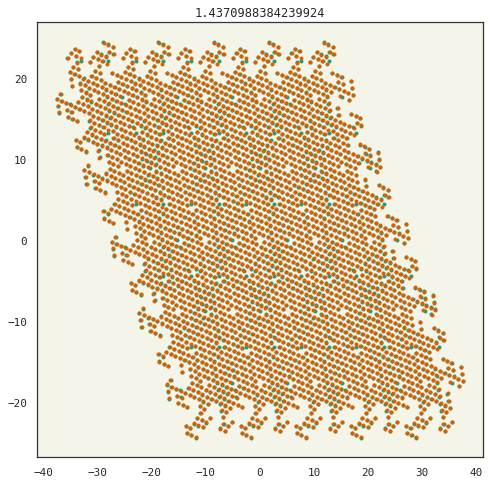

In [24]:
plt.figure(figsize=(8, 8))
plt.title(f"{nd}")
plt.plot(config[:, 0], config[:, 1], ".")
plt.plot(config2[:, 0], config2[:, 1], ".")

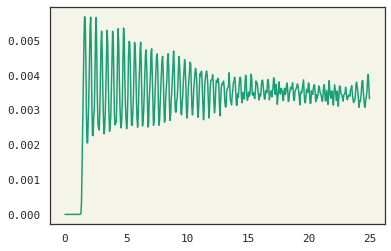

In [25]:
plt.plot(time, csm)

In [68]:
# make a movie
import moviepy.editor as editor
from moviepy.video.io.bindings import mplfig_to_npimage


def plot_traj(traj, title='@_172135352171_', color='#333333', fps=60, M=0, cmap='Reds_r'):
    T, N, D = traj.shape    
    fps = fps
    duration = T / fps + 2
    dpi = 90
    fig, ax = plt.subplots(figsize=(1920 / dpi, 1000 / dpi), dpi=dpi)
    cx, cy = np.mean(traj[-1,:, :2], axis=0)
    tc = [colors[i % len(colors)] for i in range(N)]#np.linalg.norm(traj[-1] - np.array([cx, cy]), axis=-1)
    points = [ax.scatter(traj[0,:,0], traj[0,:,1], cmap=cmap,
                         c=tc, marker='o', linewidths=1, s=3**2, edgecolors='#999')]
    ax.set_facecolor('#f5f4e9')
    fig.patch.set_facecolor('#f5f4e9')
    title = ax.set_title(title, fontsize=32, color='#333333',fontname='monospace')
    ax.axis('off')    
    xlim = np.min(traj[-1, :, 0]), np.max(traj[-1, :, 0])
    ylim = np.min(traj[-1, :, 1]), np.max(traj[-1, :, 1])
    dx = xlim[1] - xlim[0]    
    dy = ylim[1] - ylim[0]
    s = 0.75
    xlim = [cx - dx * s, cx + dx * s]
    ylim = [cy - dy * s, cy + dy * s]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')    
    plt.tight_layout()
    def make_frame(t):
        i = int(t  * fps)
        i = min(i, T-1)
        points[0].remove()        
        points[0] = ax.scatter(traj[i,:,0], traj[i,:,1], cmap=cmap,
                               c=tc, marker='o',linewidths=0, s=4**2, edgecolors='#999')
        plt.draw()
        return mplfig_to_npimage(fig)

    return editor.VideoClip(make_frame, duration=duration)
def write_video(clips, output, fps=60, transition=0.25):
    composite = editor.concatenate(clips[:1] + [c.crossfadein(transition) for c in clips[1:]], 
                                   padding=-transition, method='compose')   
    composite.write_videofile(output, fps=fps, preset='fast', ffmpeg_params=['-tune', 'animation', '-crf', '18'])
    #composite.write_gif(output, fps=60)

In [ ]:
def run_sim(
    n, number_density, group, images, w=None, retries=50, pos_frames=0, steps=10**6
):
    for i in range(retries):
        print("Trying on ", i)
        try:
            np.random.seed(i)
            cell = symd.groups.get_cell(number_density, group, 2, n, w)
            md = symd.Symd(
                nparticles=n,
                cell=cell,
                ndims=2,
                images=images,
                force="lj",
                wyckoffs=w,
                group=group,
                steps=steps,
                exeDir="quasi",
                start_temperature=0.5,
                temperature=0.2,
                pressure=0.01,
            )
            md.remove_overlap()
            md.runParams["box_update_period"] = 25
            md.runParams["langevin_gamma"] = 0.05
            md.log_positions(frames=pos_frames)
            try:
                md.run()
            except RuntimeError as e:
                d = md.number_density()
                if d < 0.5:
                    print("Not dense enough, retrying", d)
                    continue

            # Basically E-min
            md.runParams["start_temperature"] = 0.1
            md.runParams["temperature"] = None
            md.runParams["start_temperature"] = 0
            md.runParams["langevin_gamma"] = 0.5
            md.runParams["Pressure"] = None
            md.runParams["box_update_period"] = 0
            md.runParams["steps"] = steps // 10
            if pos_frames > 0:
                md.log_positions(filename="equil.xyz", frames=pos_frames // 10)
            try:
                md.run()
            except RuntimeError as e:
                continue
            config = md.positions[-1]
            break
        except RuntimeError as e:
            print(e)
            md = None
    return md
md = run_sim(32, 0.01, 16, [2, 0], w=[1], pos_frames=2000)

Trying on  0
{"steps": 1000000, "n_particles": 32, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.05, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.2, "pressure": 0.01, "box_update_period": 25, "start_temperature": 0.2, "thermostat": "baoab", "force_type": "lj", "final_positions": "quasi/final_positions.dat", "cell_log_file": "quasi/cell_log_file.dat", "print_period": 10000.0, "cell": [39.3388, 0.0, 0.0, 41.5181], "lj_epsilon": 1, "lj_sigma": 1, "images": [2, 0], "wyckoffs": [{"group": "quasi/group-16-00.json", "n_particles": 1}], "start_positions": "quasi/final_positions.dat", "group": "quasi/group-16.json", "position_log_period": 500, "positions_log_file": "quasi/positions.xyz"}
Info: You are running version bdfa of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-16 with 31 particles and 6 members
Info: Loaded group group-16-0 with 1 particles and 3 members
Info: U

In [ ]:
md.positions.shape

In [ ]:
c = plot_traj(md.positions, title=titles[16])
write_video([c], 'test.mp4')

In [ ]:
# Turned off
if False:
    from multiprocessing import Pool

    cdf = None
    results = []
    trajs = {}

    with Pool() as pool:
        for N in [8, 16, 32, 128]:
            for i, t in enumerate(titles):
                W = len(symd.groups.load_group(i + 1, 2)["specpos"])
                for j in range(1 + W):
                    wycks = None if j == 0 else [1] * j
                    name = f"{t}-w{j}-n{N}"
                    job = pool.apply_async(crystal, (N, i + 1, wycks))
                    # job = crystal(N, i+1, wycks)
                    results.append((t, name, N, j, job))

        for r in results:
            t, name, N, j, ar = r
            print("Getting result for ", name)
            res = ar.get()
            # res = ar
            if res is None:
                continue
            config, config2, nd, csm, traj, time = res
            T = len(csm)

            df2 = pd.DataFrame(
                {
                    "Group": [t] * T,
                    "Traj": [name] * T,
                    "rho": [nd] * T,
                    "N": [N] * T,
                    "Wyckoffs": [str(j)] * T,
                    "RMSD": csm,
                    "Time": time,
                }
            )
            if cdf is None:
                cdf = df2
            else:
                cdf = pd.concat((cdf, df2))
            trajs[name] = traj

    cdf.reset_index(inplace=True)
    cdf.to_pickle("atlas2d.pkl.gz")
    with open("atlas2d.traj.pkl", "wb") as f:
        pickle.dump(trajs, f, pickle.HIGHEST_PROTOCOL)

### Plot Figure

In [ ]:
urllib.request.urlretrieve(
    "https://www.dropbox.com/s/m6gi1ecv66ylm06/atlas2d.traj.pkl.gz?dl=1",
    "atlas2d.traj.pkl.gz",
)
urllib.request.urlretrieve(
    "https://www.dropbox.com/s/smn8tvljxhlp75f/atlas2d.pkl.gz?dl=1", "atlas2d.pkl.gz"
)

cdf = pd.read_pickle("atlas2d.pkl.gz")
with gzip.open("atlas2d.traj.pkl.gz", "rb") as f:
    trajs = pickle.load(f)

In [ ]:
def plot_config(pos, figsize=(1.5, 1.5), color="#333333"):
    N, D = pos.shape
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(
        pos[:, 0],
        pos[:, 1],
        color=color,
        marker="o",
        markersize=8,
        markeredgewidth=0.0,
        linestyle="None",
    )
    ax.set_facecolor("#f5f4e9")
    fig.patch.set_facecolor("#f5f4e9")
    ax.axis("off")
    # want about 64 points
    # q = max(0.05, min(0.5, 64 / N))
    # xlim = np.quantile(pos[:,0], [0.5 - q, 0.5 + q])
    # ylim = np.quantile(pos[:,1], [0.5 - q, 0.5 + q])
    xlim = (-3, 3)
    ylim = (-3, 3)
    ax.set_aspect("equal")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    plt.tight_layout()
    return skunk.pltsvg(fig=fig)


skunk.display(plot_config(trajs["pg-w0-n16"][0]))

In [ ]:
top = cdf[cdf.Time == cdf.Time.max()].sort_values(by=["RMSD"])[:25]
for r, t in zip(top.RMSD.values, top.Traj.values):
    plot_config(trajs[t][0])
    plt.title(f"{t} = {r}")

In [ ]:
replaces = []


def annotate_config(rmsd, traj, time, wyckoffs, color):
    late_rmsd = rmsd.where(time > 15)
    idx = late_rmsd.argmin()
    label = traj.iloc[idx]
    w = wyckoffs.iloc[idx]
    x = time.iloc[idx]
    y = rmsd.iloc[idx]
    if y > 1:
        x = 0
        y = 0
    replaces.append((label, f"C{w}"))
    ax = plt.gca()
    box = skunk.Box(25, 25, label)
    ab = mpl.offsetbox.AnnotationBbox(
        box,
        (x, y),
        pad=0,
        bboxprops=dict(edgecolor="#333", linewidth=1),
        xybox=(0.7 if x == 0 else 0.2, 0.7),
        xycoords="data",
        boxcoords="axes fraction",
        arrowprops=dict(arrowstyle="->", color="#333"),
    )

    ax.add_artist(ab)


g = sns.relplot(
    data=cdf.query("rho > 0.5"),
    x="Time",
    y="RMSD",
    kind="line",
    hue="Wyckoffs",
    col="Group",
    col_wrap=6,
    aspect=1,
    linewidth=1,
    style="N",
    height=1.75,
    palette="Dark2",
    hue_order=[str(i) for i in range(9)],
)
plt.ylim(-0.1, 1)
# sns.move_legend(g, "lower right", bbox_to_anchor=(0.9,0.1), ncol=3)
g.map(annotate_config, "RMSD", "Traj", "Time", "Wyckoffs").set_axis_labels(
    "Time", "RMSD"
)

main_svg = skunk.pltsvg()
svg = skunk.insert(
    {l: plot_config(trajs[l][0], color=c) for l, c in replaces}, svg=main_svg
)
skunk.display(svg)
with open("atlas.svg", "w") as f:
    f.write(svg)

In [ ]:
cdf.query("rho > 0.5").Traj.unique().shape